In [2]:
# Cell 1: ignore warnings + standard libs
import warnings
warnings.filterwarnings("ignore")

import os
import time
import random
import shutil
from pathlib import Path
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors  # for custom colormaps

# PyTorch and segmentation libs
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import cv2
import albumentations as A
from torchvision.transforms import functional as TF

# set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [3]:
3

3

In [4]:
# Cell 2: dataset paths & globals
DATASET_NAME = 'landcoverai'
DATA_ROOT    = f"../input/{DATASET_NAME}"
IMGS_DIR     = os.path.join(DATA_ROOT, "images")
MASKS_DIR    = os.path.join(DATA_ROOT, "masks")

# Where we'll dump our tiles and txt splits
OUTPUT_DIR   = "output"  
if Path(OUTPUT_DIR).exists():
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# List of raw files
IMG_PATHS  = sorted(glob.glob(os.path.join(IMGS_DIR, "*.tif")))
MASK_PATHS = sorted(glob.glob(os.path.join(MASKS_DIR, "*.tif")))

# Tile size
IMAGE_SIZE = 512

# Color map for visualization (0=bg,1=bldg,2=woodland,3=water,4=road)
labels_cmap = matplotlib.colors.ListedColormap([
    "#000000","#A9A9A9","#8B8680","#D3D3D3","#FFFFFF"
])


In [5]:
# Cell 3: split raw .tif into jpg/png tiles
def split_images(tile_size=IMAGE_SIZE):
    tic = time.time()
    for img_path, mask_path in tqdm(zip(IMG_PATHS, MASK_PATHS), total=len(IMG_PATHS)):
        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        base = Path(img_path).stem
        k = 0
        for y in range(0, img.shape[0], tile_size):
            for x in range(0, img.shape[1], tile_size):
                img_tile  = img[y:y+tile_size,  x:x+tile_size]
                m_tile    = mask[y:y+tile_size, x:x+tile_size]
                if img_tile.shape[:2] == (tile_size, tile_size):
                    cv2.imwrite(f"{OUTPUT_DIR}/{base}_{k}.jpg", img_tile)
                    cv2.imwrite(f"{OUTPUT_DIR}/{base}_{k}_m.png", m_tile)
                    k += 1
    mins, sec = divmod(time.time() - tic, 60)
    print(f"Splitting done in {mins:.0f}m {sec:.1f}s.")

split_images()


100%|██████████| 41/41 [01:50<00:00,  2.70s/it]

Splitting done in 1m 50.6s.


In [6]:
# run this cell *after* split_images()
tile_files = sorted(Path("output").glob("*.jpg"))
tile_ids   = [fp.stem for fp in tile_files]        # e.g. "M-33-20-D-c-4-2_308"
random.shuffle(tile_ids)
n = len(tile_ids)
n_train = int(0.8*n)
n_val   = int(0.1*n)
with open("train.txt","w") as f:  f.write("\n".join(tile_ids[:n_train]))
with open("val.txt","w")   as f:  f.write("\n".join(tile_ids[n_train:n_train+n_val]))
with open("test.txt","w")  as f:  f.write("\n".join(tile_ids[n_train+n_val:]))


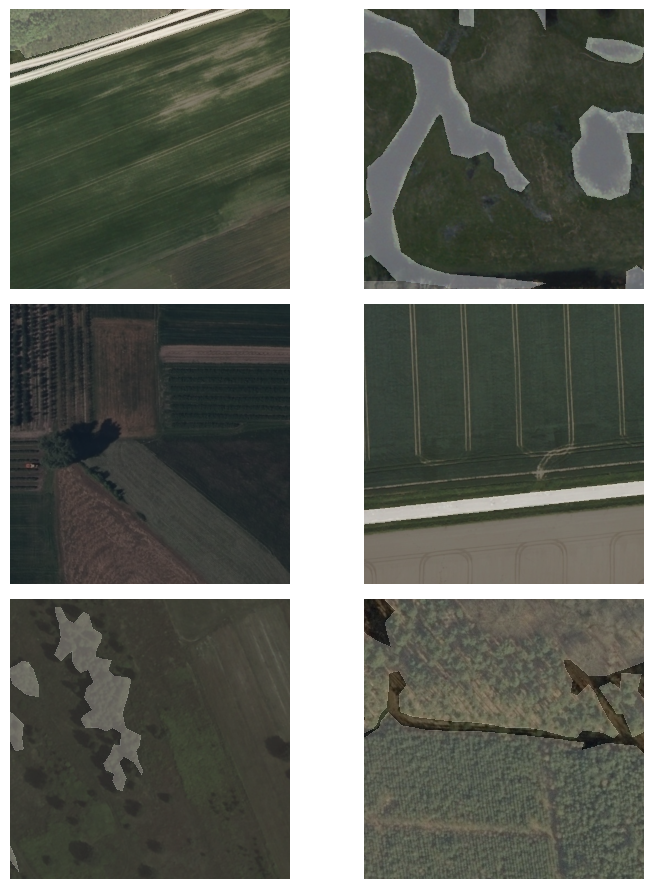

In [7]:
# Cell 4: optional—quick sanity plot of a few tiles
def visualize_dataset(num_samples=6):
    all_imgs = glob.glob(f"{OUTPUT_DIR}/*.jpg")
    sample   = random.sample(all_imgs, num_samples)
    fig, axs = plt.subplots(nrows=num_samples//2, ncols=2, figsize=(8, num_samples*1.5))
    for ax, img_fp in zip(axs.flatten(), sample):
        img   = cv2.imread(img_fp)[:,:,::-1] / 255.0
        mask  = cv2.imread(img_fp.replace(".jpg","_m.png"))[:,:,1]
        ax.imshow(img); ax.axis("off")
        ax.imshow(mask, cmap=labels_cmap, alpha=0.4, vmin=0, vmax=4)
    plt.tight_layout()
    plt.show()

visualize_dataset()


In [8]:
# Cell 6 (revised): define Dataset with split‐file filtering
class SegmentationDataset(Dataset):
    def __init__(self, mode="train", transforms=None):
        assert mode in {"train","val","test"}, "mode must be train/val/test"
        self.mode       = mode
        self.transforms = transforms
        self.output_dir = OUTPUT_DIR

        # Read split from input folder
        split_fpath = os.path.join(DATA_ROOT, f"{mode}.txt")
        if not os.path.exists(split_fpath):
            raise FileNotFoundError(f"Could not find split file: {split_fpath}")
        with open(split_fpath) as f:
            raw_ids = f.read().splitlines()

        # Only keep IDs whose image+mask files actually exist
        self.ids = []
        missing = 0
        for tid in raw_ids:
            img_fp  = os.path.join(self.output_dir, f"{tid}.jpg")
            msk_fp  = os.path.join(self.output_dir, f"{tid}_m.png")
            if os.path.isfile(img_fp) and os.path.isfile(msk_fp):
                self.ids.append(tid)
            else:
                missing += 1
        if missing:
            print(f"[{mode}] WARNING: {missing} split entries had no tile files and were skipped")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        tid    = self.ids[idx]
        img_fp = os.path.join(self.output_dir, f"{tid}.jpg")
        msk_fp = os.path.join(self.output_dir, f"{tid}_m.png")

        img  = cv2.imread(img_fp)
        mask = cv2.imread(msk_fp)[:, :, 1]

        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug["image"], aug["mask"]

        img  = torch.from_numpy(img.transpose(2,0,1)).float() / 255.0
        mask = torch.from_numpy(mask).long()
        return img, mask


In [9]:
# Cell 7: define Albumentations transforms
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

val_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
])


In [10]:
# Cell 8: instantiate DataLoaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_ds = SegmentationDataset("train", transforms=train_transforms)
val_ds   = SegmentationDataset("val",   transforms=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train tiles: {len(train_ds)}, Val tiles: {len(val_ds)}")


[train] WARNING: 434 split entries had no tile files and were skipped
[val] WARNING: 92 split entries had no tile files and were skipped
Train tiles: 7036, Val tiles: 1510


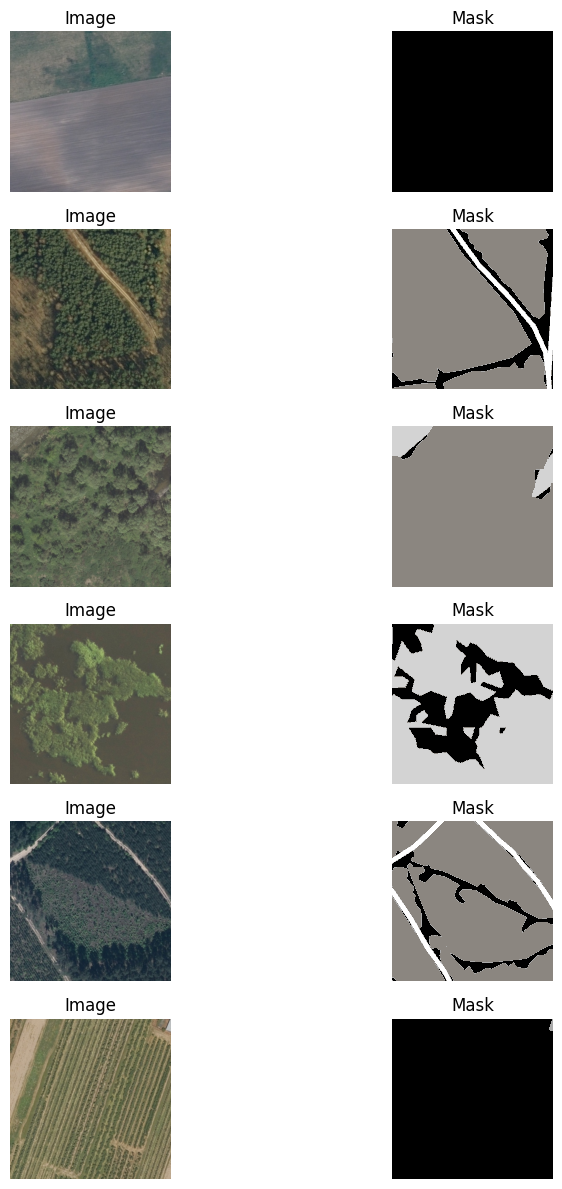

In [11]:
import glob
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define colormap for masks
labels_cmap = ListedColormap(["#000000", "#A9A9A9", "#8B8680", "#D3D3D3", "#FFFFFF"])

# Sample a few tiles from the output directory
all_imgs = glob.glob("output/*.jpg")
sample = random.sample(all_imgs, min(6, len(all_imgs)))  # up to 6 samples

# Plot images and corresponding masks
plt.figure(figsize=(10, 12))
for idx, img_path in enumerate(sample):
    img = cv2.imread(img_path)[:, :, ::-1] / 255.0
    mask = cv2.imread(img_path.replace(".jpg", "_m.png"))[:, :, 1]
    
    plt.subplot(len(sample), 2, 2*idx + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")
    
    plt.subplot(len(sample), 2, 2*idx + 2)
    plt.imshow(mask, cmap=labels_cmap, vmin=0, vmax=4)
    plt.axis("off")
    plt.title("Mask")

plt.tight_layout()
plt.show()


In [12]:
# Cell 9: define ExitHead
class ExitHead(nn.Module):
    def __init__(self, in_channels, num_classes, scale_factor):
        """
        in_channels: # of feature maps at this point
        num_classes: # segmentation labels
        scale_factor: upsampling factor to reach IMAGE_SIZE
        """
        super().__init__()
        self.conv1x1 = nn.Conv2d(in_channels, num_classes, kernel_size=1)
        self.scale   = scale_factor

    def forward(self, x):
        # project to num_classes channels, then upsample
        out = self.conv1x1(x)
        if self.scale != 1:
            out = F.interpolate(out, scale_factor=self.scale,
                                mode="bilinear", align_corners=False)
        return out


In [13]:
# Cell 10: define MultiExitUNet
class MultiExitUNet(nn.Module):
    def __init__(self, num_classes=5, base_channels=64):
        super().__init__()
        # --- Encoder (same as your vanilla U‑Net) ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, base_channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1), nn.ReLU(inplace=True)
        )
        
        # --- Decoder & Exit Heads ---
        # Up3: from bottleneck → enc3 resolution
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.exit3 = ExitHead(in_channels=base_channels*4, num_classes=num_classes,
                              scale_factor=4)  # 1/8 → full size = ×8; after two pools, ×4
        
        # Up2: to enc2 resolution
        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.exit2 = ExitHead(in_channels=base_channels*2, num_classes=num_classes,
                              scale_factor=2)
        
        # Up1: to enc1 resolution
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.exit1 = ExitHead(in_channels=base_channels, num_classes=num_classes,
                              scale_factor=1)  # at full resolution
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        b  = self.bottleneck(p3)
        
        # Decoder + Exits
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        out3 = self.exit3(d3)   # Exit head at 1/8 depth
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        out2 = self.exit2(d2)   # Exit head at 1/4 depth
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out1 = self.exit1(d1)   # Final exit at full resolution
        
        # Return early exits first, then final
        return [out3, out2, out1]


In [14]:
# Cell 12 (fixed): loss & metric setup

NUM_CLASSES = 5
exit_loss_weights = [0.3, 0.6, 1.0]
criterion = nn.CrossEntropyLoss()

def make_metrics():
    metrics = {}
    for i in range(3):
        metrics[f"exit{i+1}_acc"] = torchmetrics.Accuracy(
            task="multiclass", num_classes=NUM_CLASSES
        ).to(device)
        metrics[f"exit{i+1}_iou"] = torchmetrics.JaccardIndex(
            task="multiclass", num_classes=NUM_CLASSES
        ).to(device)
    return metrics


In [15]:
# Cell 13: one training epoch
def train_one_epoch(model, dataloader, optimizer):
    model.train()
    metrics = make_metrics()
    total_loss = 0.0
    n_batches = 0

    for imgs, masks in tqdm(dataloader, desc="Train", leave=False):
        imgs  = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()

        # Forward: list of [exit3, exit2, exit1]
        outs = model(imgs)

        # Compute weighted sum of per‑exit losses
        losses = []
        for i, out in enumerate(outs):
            loss_i = criterion(out, masks) * exit_loss_weights[i]
            losses.append(loss_i)
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

        # Update metrics per exit
        with torch.no_grad():
            for i, out in enumerate(outs):
                preds = out.argmax(dim=1)
                metrics[f"exit{i+1}_acc"].update(preds, masks)
                metrics[f"exit{i+1}_iou"].update(preds, masks)

    # Compute epoch averages
    avg_loss = total_loss / n_batches
    results = {"loss": avg_loss}
    for name, metric in metrics.items():
        results[name] = metric.compute().item()
    return results


In [16]:
# Cell 14: one validation epoch (no gradient, no backward)
@torch.no_grad()
def eval_one_epoch(model, dataloader):
    model.eval()
    metrics = make_metrics()
    total_loss = 0.0
    n_batches = 0

    for imgs, masks in tqdm(dataloader, desc="Val  ", leave=False):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        outs = model(imgs)
        # Weighted loss (for monitoring only)
        losses = [criterion(out, masks) * exit_loss_weights[i] for i, out in enumerate(outs)]
        loss = sum(losses)

        total_loss += loss.item()
        n_batches += 1

        # Update metrics
        for i, out in enumerate(outs):
            preds = out.argmax(dim=1)
            metrics[f"exit{i+1}_acc"].update(preds, masks)
            metrics[f"exit{i+1}_iou"].update(preds, masks)

    avg_loss = total_loss / n_batches
    results = {"val_loss": avg_loss}
    for name, metric in metrics.items():
        results[name] = metric.compute().item()
    return results


In [ ]:
# Cell 15: main training loop
EPOCHS = 20
LEARNING_RATE = 1e-3

model = MultiExitUNet(num_classes=NUM_CLASSES).to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

best_val_iou = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_res = train_one_epoch(model, train_loader, optimizer)
    val_res   = eval_one_epoch(model, val_loader)

    # Log & print
    res = {**{"epoch": epoch}, **train_res, **val_res}
    history.append(res)
    print(f"  Train Loss: {train_res['loss']:.4f} | "
          f"Exit1 IoU: {train_res['exit3_iou']:.3f}, {train_res['exit2_iou']:.3f}, {train_res['exit1_iou']:.3f}")
    print(f"  Val   Loss: {val_res['val_loss']:.4f} | "
          f"Exit1 IoU: {val_res['exit3_iou']:.3f}, {val_res['exit2_iou']:.3f}, {val_res['exit1_iou']:.3f}")

    # Save best model based on final exit (exit1) IoU
    final_exit_iou = val_res['exit1_iou']
    if final_exit_iou > best_val_iou:
        best_val_iou = final_exit_iou
        torch.save(model.state_dict(), "best_multi_exit_unet.pth")
        print("  >>> New best model saved!")

# Optionally: convert history to DataFrame for plotting
import pandas as pd
history_df = pd.DataFrame(history)



Epoch 1/20


  Train Loss: 1.7784 | Exit1 IoU: 0.173, 0.171, 0.158
  Val   Loss: 1.5379 | Exit1 IoU: 0.182, 0.189, 0.197
  >>> New best model saved!

Epoch 2/20


  Train Loss: 1.6675 | Exit1 IoU: 0.183, 0.188, 0.190
  Val   Loss: 1.4183 | Exit1 IoU: 0.234, 0.239, 0.238
  >>> New best model saved!

Epoch 3/20


  Train Loss: 1.5198 | Exit1 IoU: 0.229, 0.224, 0.226
  Val   Loss: 1.3333 | Exit1 IoU: 0.240, 0.236, 0.245
  >>> New best model saved!

Epoch 4/20


  Train Loss: 1.3308 | Exit1 IoU: 0.255, 0.246, 0.246
  Val   Loss: 1.1802 | Exit1 IoU: 0.253, 0.259, 0.264
  >>> New best model saved!

Epoch 5/20


  Train Loss: 1.2172 | Exit1 IoU: 0.271, 0.265, 0.273
  Val   Loss: 1.0698 | Exit1 IoU: 0.266, 0.273, 0.284
  >>> New best model saved!

Epoch 6/20


  Train Loss: 1.1327 | Exit1 IoU: 0.303, 0.301, 0.304
  Val   Loss: 0.9551 | Exit1 IoU: 0.311, 0.342, 0.346
  >>> New best model saved!

Epoch 7/20


Train:  35%|███▍      | 304/880 [03:29<06:35,  1.46it/s]

In [18]:
# Cell 16: load best model
model = MultiExitUNet(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("best_multi_exit_unet.pth", map_location=device))
model.eval()


MultiExitUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequentia

In [19]:
# Cell 17: confidence metrics
import torch.nn.functional as F

def mean_softmax_conf(logits):
    """Mean of max-softmax across pixels."""
    probs = F.softmax(logits, dim=1)        # B×C×H×W
    maxp, _ = probs.max(dim=1)             # B×H×W
    return maxp.mean(dim=(1,2))            # B

def entropy_conf(logits):
    """Negative mean entropy across pixels."""
    probs = F.softmax(logits, dim=1)
    ent = -(probs * probs.log()).sum(dim=1)  # B×H×W
    return -ent.mean(dim=(1,2))              # B


In [20]:
# Cell 18: single‑tile inference with thresholds
def infer_tile(img, thresholds=(0.8, 0.9)):
    """
    Run tile through multi-exit model.
    thresholds: (tau3, tau2) in [0,1]
    Returns: (chosen_exit, mask_pred (H×W), conf_value)
    """
    with torch.no_grad():
        outs = model(img.unsqueeze(0).to(device))  # list of 3: [out3,out2,out1]
        # compute confidences
        confs = [mean_softmax_conf(o)[0].item() for o in outs]
        # decide exit
        if confs[0] >= thresholds[0]:
            exit_idx = 0
        elif confs[1] >= thresholds[1]:
            exit_idx = 1
        else:
            exit_idx = 2
        pred = outs[exit_idx].argmax(dim=1)[0].cpu().numpy()
    return exit_idx+1, pred, confs[exit_idx]


In [21]:
# Cell 19: run inference on val set and gather stats
results = []
tau3, tau2 = 0.80, 0.90

for imgs, masks in tqdm(val_loader, desc="Infer"):
    for img, mask in zip(imgs, masks):
        exit_id, pred, conf = infer_tile(img, thresholds=(tau3,tau2))
        iou = torchmetrics.functional.jaccard_index(
            torch.from_numpy(pred), mask, task="multiclass", num_classes=NUM_CLASSES
        ).item()
        results.append({
            "exit": exit_id,
            "conf": conf,
            "iou": iou
        })

# Build DataFrame
import pandas as pd
df = pd.DataFrame(results)
exit_rates = df['exit'].value_counts(normalize=True).sort_index()
avg_iou = df.groupby('exit')['iou'].mean()
print("Exit rates:", exit_rates.to_dict())
print("Avg IoU per exit:", avg_iou.to_dict())


Infer: 100%|██████████| 189/189 [01:10<00:00,  2.68it/s]

Exit rates: {1: 0.20596026490066224, 2: 0.0013245033112582781, 3: 0.7927152317880795}
Avg IoU per exit: {1: 0.5104461113931282, 2: 0.31368929147720337, 3: 0.2923167881788005}


In [22]:
# Cell 20: plot speed vs. accuracy sweep
taus = np.linspace(0.6, 0.95, 8)
records = []
for t3 in taus:
    for t2 in taus:
        if t2 <= t3: continue
        df_tmp = []
        for imgs, masks in val_loader:
            for img, mask in zip(imgs, masks):
                exit_id, pred, _ = infer_tile(img, thresholds=(t3,t2))
                df_tmp.append(exit_id)
        rates = np.bincount(df_tmp, minlength=4)[1:] / len(df_tmp)
        # approx speedup = sum(rates[i]*(compute_fraction_i)) 
        # assume out3=25%, out2=50%, out1=100% FLOPs
        speedup = (rates[0]*0.25 + rates[1]*0.5 + rates[2]*1.0)
        records.append({"t3":t3, "t2":t2, "speedup":speedup,
                        "overall_exit1_rate":rates[2]})
df_sweep = pd.DataFrame(records)

# Plot trade‑off
plt.figure(figsize=(6,4))
plt.plot(df_sweep['overall_exit1_rate'], df_sweep['speedup'], marker='o')
plt.xlabel("Fraction exiting at final head")
plt.ylabel("Relative compute fraction")
plt.title("Speed vs. Accuracy Tradeoff")
plt.show()


KeyboardInterrupt: 

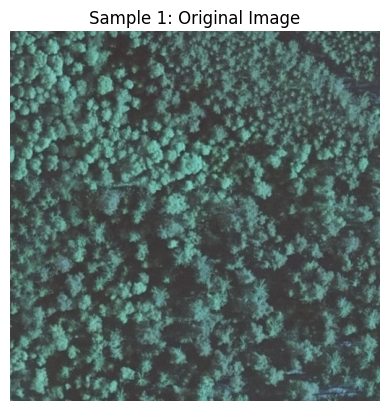

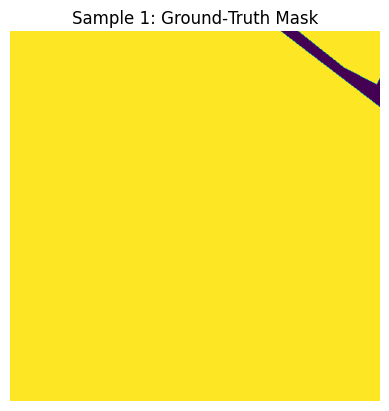

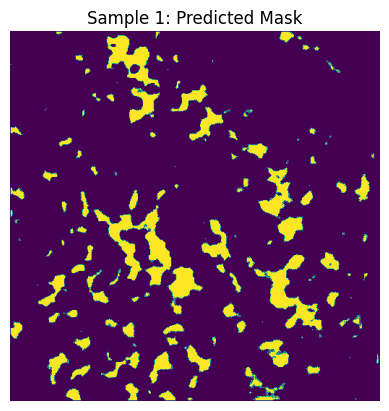

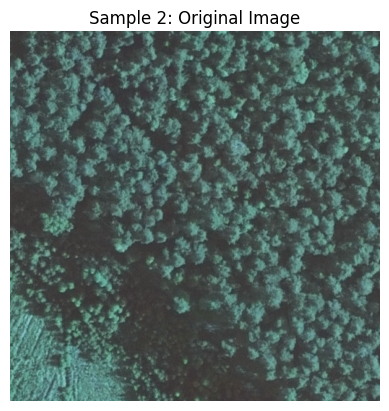

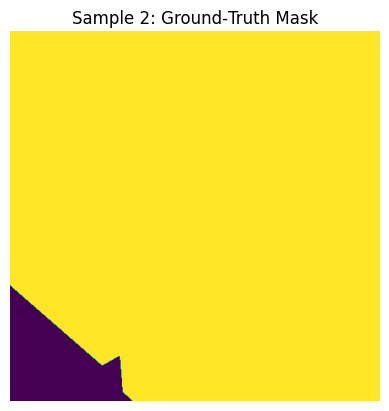

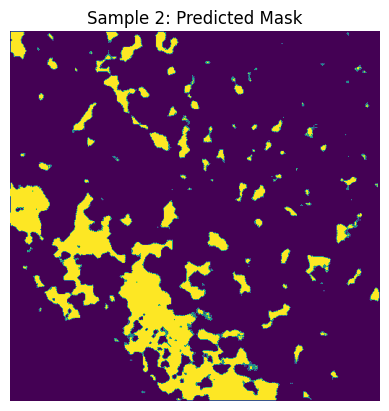

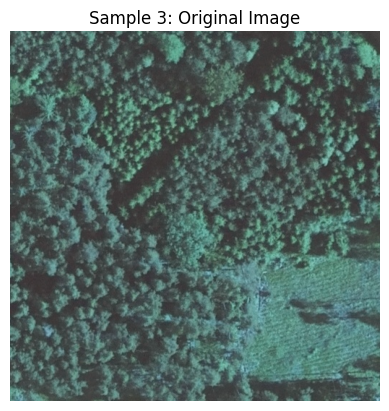

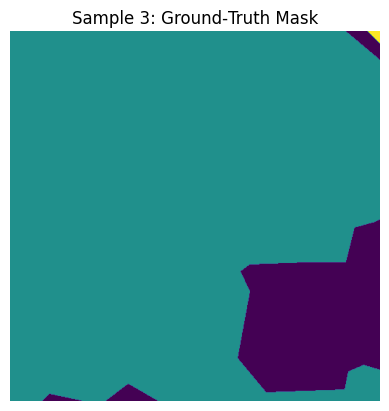

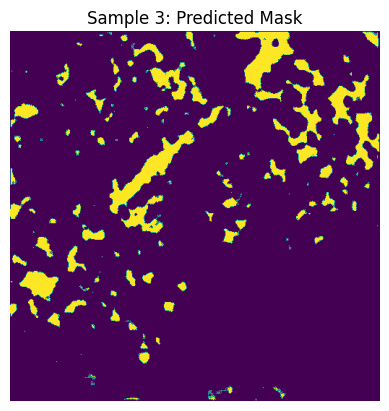

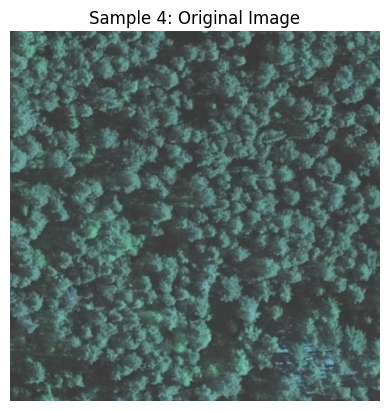

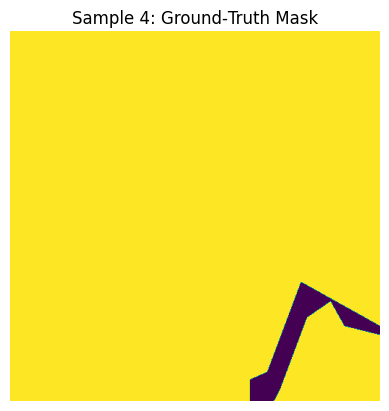

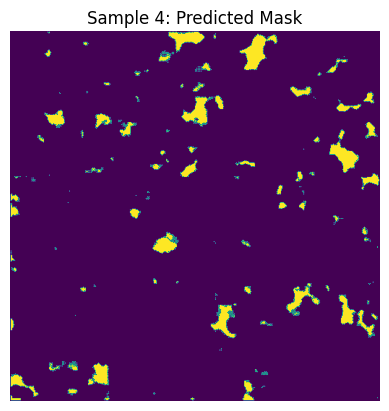

In [29]:
# ─── Cell: Visualize + Metrics ───────────────────────────────────────────────

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Number of samples to visualize
NUM_SAMPLES = 4

# Collect first few val samples
samples = []
for imgs, masks in val_loader:
    for img, mask in zip(imgs, masks):
        samples.append((img, mask))
    if len(samples) >= NUM_SAMPLES:
        break
samples = samples[:NUM_SAMPLES]

# Prepare metrics list
metrics = []

for idx, (img, gt_mask) in enumerate(samples, start=1):
    # Inference (full-resolution exit)
    with torch.no_grad():
        outs = model(img.unsqueeze(0).to(device))
        pred_mask = outs[-1].argmax(dim=1)[0].cpu().numpy()
    gt = gt_mask.numpy()

    # Compute per-class IoU
    ious = {}
    for c in range(NUM_CLASSES):
        inter = np.logical_and(pred_mask == c, gt == c).sum()
        uni   = np.logical_or (pred_mask == c, gt == c).sum()
        ious[f"iou_class_{c}"] = inter/uni if uni>0 else np.nan

    # Compute overall accuracy
    acc = (pred_mask == gt).mean()
    metrics.append({"sample": idx, "accuracy": acc, **ious})

    # Plot Original
    plt.figure()
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.title(f"Sample {idx}: Original Image")
    plt.axis("off")
    plt.show()

    # Plot GT Mask
    plt.figure()
    plt.imshow(gt)
    plt.title(f"Sample {idx}: Ground‑Truth Mask")
    plt.axis("off")
    plt.show()

    # Plot Pred Mask
    plt.figure()
    plt.imshow(pred_mask)
    plt.title(f"Sample {idx}: Predicted Mask")
    plt.axis("off")
    plt.show()

# Build DataFrame and display
df = pd.DataFrame(metrics).set_index("sample")


In [30]:
df

,accuracy,iou_class_0,iou_class_1,iou_class_2,iou_class_3,iou_class_4
sample,,,,,,
1,0.116425,0.009705,NaN,0.108707,NaN,NaN
2,0.193733,0.065982,NaN,0.145037,NaN,NaN
3,0.228519,0.148551,NaN,0.108617,NaN,0.0
4,0.062660,0.021691,NaN,0.042767,NaN,NaN
